In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Subset, random_split


class FederatedDataBuilder:
    def __init__(self, root='./data', val_split_ratio=0.1, K=100):

        self.root = root
        self.K = K
        self.val_split_ratio = val_split_ratio

        # Image transformations for DINO ViT (requires 224x224)
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
        ])

        # Load CIFAR-100
        full_train_dataset = torchvision.datasets.CIFAR100(
            root=self.root, train=True, download=True, transform=self.transform
        )
        self.test_dataset = torchvision.datasets.CIFAR100(
            root=self.root, train=False, download=True, transform=self.transform
        )

        # Create train-validation split
        val_size = int(len(full_train_dataset) * val_split_ratio)
        train_size = len(full_train_dataset) - val_size

        self.train_dataset, self.val_dataset = random_split(
            full_train_dataset, [train_size, val_size],
            generator=torch.Generator().manual_seed(42)
        )

        # Extract labels for Non-IID partitioning
        self.train_indices = self.train_dataset.indices
        self.train_targets = np.array(full_train_dataset.targets)[self.train_indices]

    def get_iid_partition(self):

        print(f"Creating IID partition for {self.K} clients...")

        num_items = int(len(self.train_dataset) / self.K)
        dict_users = {}
        all_idxs = list(range(len(self.train_dataset)))
        np.random.shuffle(all_idxs)

        for i in range(self.K):
            dict_users[i] = set(all_idxs[i * num_items : (i + 1) * num_items])

        return dict_users

    def get_non_iid_partition(self, Nc):

        print(f"Creating Non-IID partition (Nc={Nc}) for {self.K} clients...")

        # Sort by labels
        idxs = np.arange(len(self.train_dataset))
        labels = self.train_targets
        idxs_labels = np.vstack((idxs, labels))
        idxs_labels = idxs_labels[:, idxs_labels[1, :].argsort()]
        idxs = idxs_labels[0, :]

        # Create shards
        total_shards = self.K * Nc
        shard_size = int(len(self.train_dataset) / total_shards)
        idx_shard = [idxs[i*shard_size : (i+1)*shard_size] for i in range(total_shards)]

        # Assign shards to clients
        dict_users = {i: np.array([], dtype='int64') for i in range(self.K)}
        available_shards = list(range(total_shards))

        for i in range(self.K):
            for _ in range(Nc):
                shard_idx = np.random.choice(available_shards)
                dict_users[i] = np.concatenate((dict_users[i], idx_shard[shard_idx]))
                available_shards.remove(shard_idx)

        return dict_users

    def verify_partition(self, dict_users):

        print("\n" + "="*50)
        print("Verifying Partition")
        print("="*50)

        # Check 1: Total samples
        all_indices = set()
        for client_indices in dict_users.values():
            all_indices.update(client_indices)

        total = len(all_indices)
        expected = len(self.train_dataset)
        print(f"Total samples: {total}/{expected}")

        # Check 2: No overlap
        sum_samples = sum(len(indices) for indices in dict_users.values())
        if sum_samples != total:
            print(f"✗ Overlap detected!")
            return False
        print(f"No overlap")

        # Check 3: Class distribution
        classes_per_client = []
        for client_indices in dict_users.values():
            if isinstance(client_indices, set):
                client_indices = list(client_indices)
            client_labels = self.train_targets[client_indices]
            num_classes = len(np.unique(client_labels))
            classes_per_client.append(num_classes)

        avg_classes = np.mean(classes_per_client)
        print(f"✓ Avg classes per client: {avg_classes:.1f}")
        print("="*50 + "\n")

        return total == expected

    def visualize_distribution(self, dict_users, save_path=None, title=""):

        num_clients = len(dict_users)
        num_classes = 100

        # Build distribution matrix
        matrix = np.zeros((num_clients, num_classes))

        for client_id, client_indices in dict_users.items():
            if isinstance(client_indices, set):
                client_indices = list(client_indices)

            client_labels = self.train_targets[client_indices]
            unique_classes, counts = np.unique(client_labels, return_counts=True)

            for cls, count in zip(unique_classes, counts):
                matrix[client_id, cls] = count

        # Plot
        plt.figure(figsize=(12, 6))
        plt.imshow(matrix, aspect='auto', cmap='YlOrRd', interpolation='nearest')
        plt.colorbar(label='Number of Samples')
        plt.xlabel('Class ID', fontsize=12)
        plt.ylabel('Client ID', fontsize=12)
        plt.title(f'Data Distribution - {title}', fontsize=14)
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
            print(f"Figure saved to {save_path}")

        plt.show()





/kaggle/input/fedrateddataset/cifar-100-python/meta
/kaggle/input/fedrateddataset/cifar-100-python/file.txt~
/kaggle/input/fedrateddataset/cifar-100-python/test
/kaggle/input/fedrateddataset/cifar-100-python/train


Creating IID partition for 100 clients...

Verifying Partition
Total samples: 45000/45000
No overlap
✓ Avg classes per client: 99.0

Figure saved to iid.png


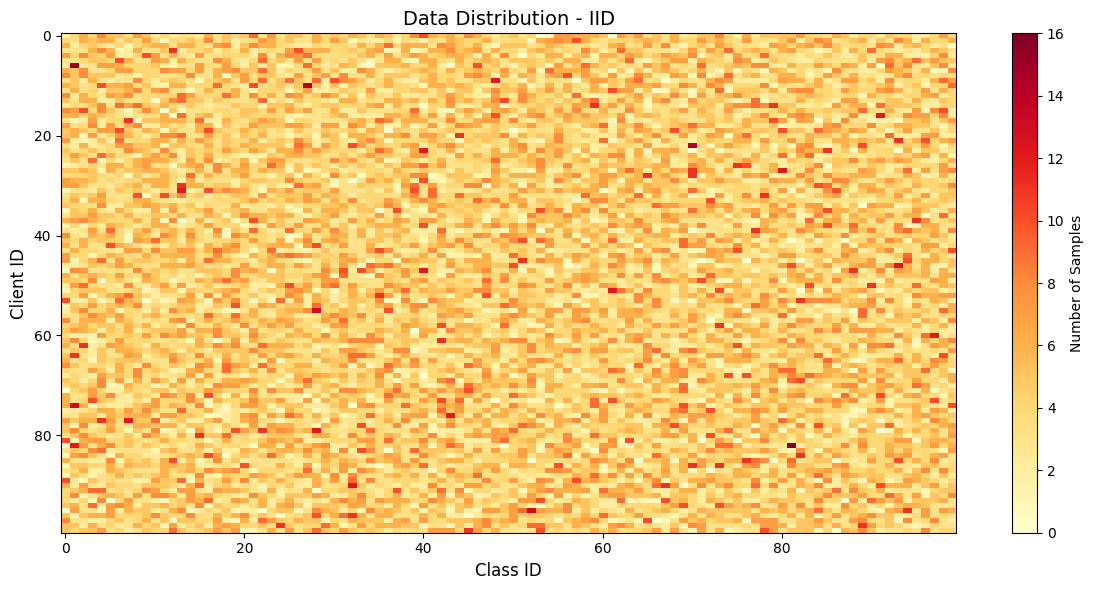

Creating Non-IID partition (Nc=5) for 100 clients...

Verifying Partition
Total samples: 45000/45000
No overlap
✓ Avg classes per client: 5.8

Figure saved to non_iid_nc5.png


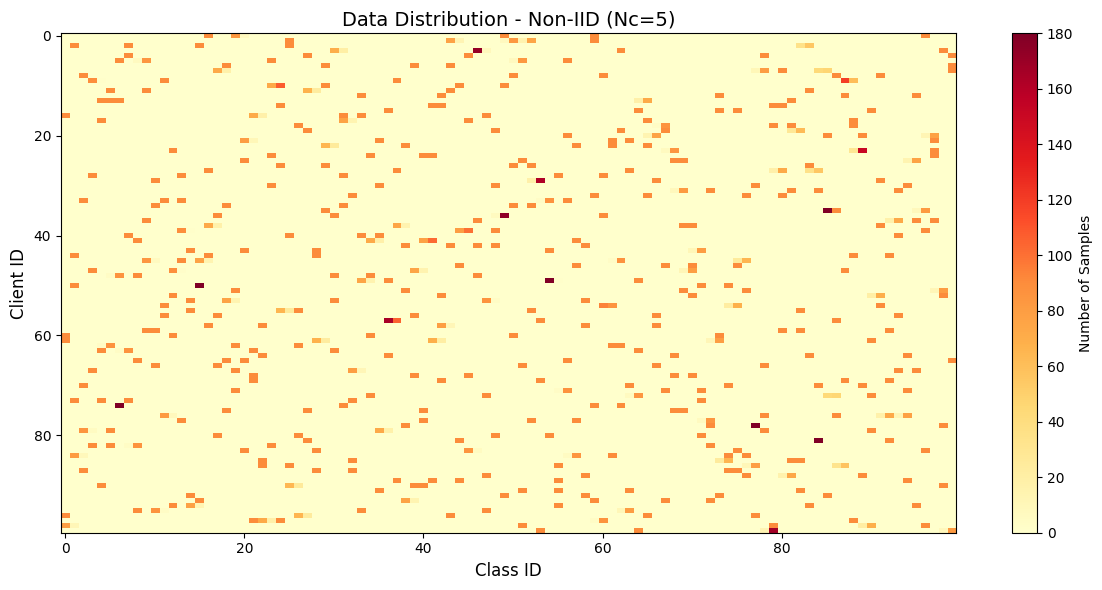

In [11]:
# test
if __name__ == "__main__":
    # Initialize
    data_builder = FederatedDataBuilder(K=100)

    # IID partition
    dict_users_iid = data_builder.get_iid_partition()
    data_builder.verify_partition(dict_users_iid)
    data_builder.visualize_distribution(dict_users_iid,
                                       save_path='iid.png',
                                       title='IID')

    # Non-IID partition
    dict_users_nc5 = data_builder.get_non_iid_partition(Nc=5)
    data_builder.verify_partition(dict_users_nc5)
    data_builder.visualize_distribution(dict_users_nc5,
                                       save_path='non_iid_nc5.png',
                                       title='Non-IID (Nc=5)')

In [ ]:
"""
FedAvg with Non-IID Data Distribution
======================================
Implements experiments required by the project:
- Nc ∈ {1, 5, 10, 50} (classes per client)
- J ∈ {4, 8, 16} (local steps)
- K=100, C=0.1 (100 clients, 10% sampling)

Based on project specification page 3-4.
"""

import torch
import torch.nn as nn
import torch.optim as optim
import copy
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
from collections import defaultdict
import random


# Load DINO backbone once globally
print("="*70)
print("Loading DINO backbone (ONE TIME ONLY)...")
print("="*70)
GLOBAL_DINO_BACKBONE = torch.hub.load('facebookresearch/dino:main', 'dino_vits16')
print("✓ DINO backbone loaded and cached globally")
print("="*70)


class DINOCIFAR100(nn.Module):
    """DINO ViT-S/16 for CIFAR-100"""
    def __init__(self, num_classes=100):
        super().__init__()
        self.backbone = GLOBAL_DINO_BACKBONE
        
        # Freeze backbone
        for param in self.backbone.parameters():
            param.requires_grad = False
        
        # Trainable classification head
        self.head = nn.Linear(384, num_classes)
        nn.init.xavier_uniform_(self.head.weight)
        nn.init.zeros_(self.head.bias)
    
    def forward(self, x):
        with torch.no_grad():
            features = self.backbone(x)
        return self.head(features)


def create_non_iid_partition(dataset, K, Nc, seed=42):
    """
    Create Non-IID data partition.
    
    Args:
        dataset: CIFAR-100 training dataset
        K: Number of clients
        Nc: Number of classes per client
        seed: Random seed for reproducibility
    
    Returns:
        client_dict: {client_id: [sample_indices]}
    """
    np.random.seed(seed)
    random.seed(seed)
    
    num_classes = 100
    
    # Group samples by class
    class_to_indices = defaultdict(list)
    for idx, (_, label) in enumerate(dataset):
        class_to_indices[label].append(idx)
    
    # Shuffle indices within each class
    for label in class_to_indices:
        np.random.shuffle(class_to_indices[label])
    
    print(f"\n{'='*70}")
    print(f"Creating Non-IID Partition (Nc={Nc})")
    print(f"{'='*70}")
    
    if Nc == 1:
        # Each client gets one class
        # Need to handle the case where K > num_classes
        client_dict = {}
        
        for client_id in range(K):
            # Assign class in round-robin fashion
            assigned_class = client_id % num_classes
            
            # Calculate how many samples this client should get
            samples_per_client = len(class_to_indices[assigned_class]) // (K // num_classes + 1)
            
            # Get indices for this client
            start_idx = (client_id // num_classes) * samples_per_client
            end_idx = start_idx + samples_per_client
            
            client_dict[client_id] = class_to_indices[assigned_class][start_idx:end_idx]
        
        print(f"Distribution: Each client has 1 class")
        print(f"Example: Client 0 has class {0 % num_classes}")
        
    else:
        # Each client gets Nc classes
        client_dict = {}
        
        # Assign classes to clients
        # Strategy: Randomly assign Nc classes to each client
        all_classes = list(range(num_classes))
        
        for client_id in range(K):
            # Randomly select Nc classes for this client
            np.random.seed(seed + client_id)  # Deterministic per client
            assigned_classes = np.random.choice(all_classes, Nc, replace=False)
            
            # Collect all samples from assigned classes
            client_indices = []
            for cls in assigned_classes:
                # Divide samples of this class among clients that have it
                # For simplicity, give each client a portion
                samples_in_class = class_to_indices[cls]
                portion = len(samples_in_class) // K  # Rough estimate
                
                start = (client_id * portion) % len(samples_in_class)
                end = start + max(1, portion)
                
                client_indices.extend(samples_in_class[start:end])
            
            client_dict[client_id] = client_indices
            
            if client_id == 0:
                print(f"Example: Client 0 assigned classes: {sorted(assigned_classes)}")
    
    # Verify
    total_samples = sum(len(indices) for indices in client_dict.values())
    avg_samples = total_samples / K
    
    print(f"Total samples distributed: {total_samples}/{len(dataset)}")
    print(f"Avg samples per client: {avg_samples:.1f}")
    print(f"{'='*70}\n")
    
    return client_dict


def verify_non_iid_partition(dataset, client_dict, Nc):
    """Verify the Non-IID partition quality"""
    print(f"\n{'='*50}")
    print(f"Verifying Non-IID Partition (Nc={Nc})")
    print(f"{'='*50}")
    
    # Check number of classes per client
    client_class_counts = []
    
    for client_id, indices in client_dict.items():
        if len(indices) == 0:
            continue
            
        # Get unique classes in this client
        labels = [dataset[idx][1] for idx in indices]
        unique_classes = len(set(labels))
        client_class_counts.append(unique_classes)
    
    avg_classes = np.mean(client_class_counts)
    std_classes = np.std(client_class_counts)
    
    print(f"Classes per client:")
    print(f"  Expected: {Nc}")
    print(f"  Actual avg: {avg_classes:.2f} ± {std_classes:.2f}")
    print(f"  Min: {min(client_class_counts)}, Max: {max(client_class_counts)}")
    
    # Check sample distribution
    sample_counts = [len(indices) for indices in client_dict.values()]
    print(f"\nSamples per client:")
    print(f"  Avg: {np.mean(sample_counts):.1f} ± {np.std(sample_counts):.1f}")
    print(f"  Min: {min(sample_counts)}, Max: {max(sample_counts)}")
    
    print(f"{'='*50}\n")


def fed_avg_aggregate(global_model, local_weights, client_sample_counts):
    """FedAvg aggregation"""
    global_dict = copy.deepcopy(global_model.state_dict())
    total_samples = sum(client_sample_counts)
    
    # Initialize to zero
    for k in global_dict.keys():
        if 'num_batches_tracked' not in k and 'backbone' not in k:
            global_dict[k] = global_dict[k] * 0.0
    
    # Weighted average
    for i in range(len(local_weights)):
        ratio = client_sample_counts[i] / total_samples
        weights = local_weights[i]
        for k in global_dict.keys():
            if 'num_batches_tracked' not in k and 'backbone' not in k:
                global_dict[k] += weights[k] * ratio
    
    return global_dict


class LocalClient:
    """Local client for federated training"""
    
    def __init__(self, client_id, dataset, indices, device):
        self.client_id = client_id
        self.indices = indices
        self.device = device
        
        self.trainloader = DataLoader(
            Subset(dataset, list(indices)),
            batch_size=64,
            shuffle=True,
            num_workers=2,
            pin_memory=True
        )
    
    def train(self, global_weights, local_steps, lr=0.1):
        """Train for J local steps"""
        
        # Create local model
        local_model = DINOCIFAR100(num_classes=100).to(self.device)
        local_model.load_state_dict(global_weights, strict=False)
        local_model.train()
        
        # Optimizer
        optimizer = optim.SGD(
            local_model.head.parameters(),
            lr=lr,
            momentum=0.9,
            weight_decay=1e-4
        )
        
        criterion = nn.CrossEntropyLoss()
        
        # Train for J steps
        step_count = 0
        losses = []
        iterator = iter(self.trainloader)
        
        while step_count < local_steps:
            try:
                inputs, targets = next(iterator)
            except StopIteration:
                iterator = iter(self.trainloader)
                inputs, targets = next(iterator)
            
            inputs, targets = inputs.to(self.device), targets.to(self.device)
            
            optimizer.zero_grad()
            outputs = local_model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(local_model.head.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            losses.append(loss.item())
            step_count += 1
        
        return local_model.state_dict(), sum(losses)/len(losses)


def evaluate_global(model, test_loader, device):
    """Evaluate global model"""
    model.eval()
    correct = 0
    total = 0
    loss_sum = 0
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss_sum += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    return loss_sum / len(test_loader), 100. * correct / total


def run_fedavg_experiment(K=100, C=0.1, J=4, rounds=50, lr=0.1, 
                         Nc=None, data_builder=None):
    """
    Run FedAvg experiment.
    
    Args:
        K: Number of clients
        C: Client sampling fraction
        J: Local steps
        rounds: Communication rounds
        lr: Learning rate
        Nc: Number of classes per client (None for IID)
        data_builder: Pre-created data builder (to reuse data split)
    """
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    dist_type = f"Non-IID (Nc={Nc})" if Nc else "IID"
    
    print(f"\n{'='*70}")
    print(f"FedAvg Experiment: {dist_type}, J={J}")
    print(f"{'='*70}")
    print(f"K={K}, C={C}, J={J}, Rounds={rounds}, LR={lr}")
    print(f"Device: {DEVICE}")
    print(f"{'='*70}\n")
    
    # Data preparation
    if data_builder is None:
        data_builder = FederatedDataBuilder(val_split_ratio=0.1, K=K)
    
    # Get appropriate partition
    if Nc is None:
        # IID
        client_dict = data_builder.get_iid_partition()
    else:
        # Non-IID
        client_dict = create_non_iid_partition(
            data_builder.train_dataset, K, Nc
        )
        verify_non_iid_partition(data_builder.train_dataset, client_dict, Nc)
    
    test_loader = DataLoader(
        data_builder.test_dataset,
        batch_size=128,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )
    
    # Global model
    print("Initializing global model...")
    global_model = DINOCIFAR100(num_classes=100).to(DEVICE)
    
    history = {
        'loss': [],
        'accuracy': [],
        'round': [],
        'train_loss': []
    }
    
    # Training
    m = max(int(C * K), 1)
    print(f"Training with {m} clients per round\n")
    
    for r in range(rounds):
        selected_clients = np.random.choice(range(K), m, replace=False)
        
        local_weights = []
        client_sample_counts = []
        client_losses = []
        
        global_weights = copy.deepcopy(global_model.state_dict())
        
        # Local training
        for client_idx in selected_clients:
            if len(client_dict[client_idx]) == 0:
                continue
                
            client = LocalClient(
                client_id=client_idx,
                dataset=data_builder.train_dataset,
                indices=client_dict[client_idx],
                device=DEVICE
            )
            
            w_local, loss_local = client.train(global_weights, local_steps=J, lr=lr)
            
            local_weights.append(w_local)
            client_sample_counts.append(len(client_dict[client_idx]))
            client_losses.append(loss_local)
        
        # Aggregation
        new_weights = fed_avg_aggregate(global_model, local_weights, client_sample_counts)
        global_model.load_state_dict(new_weights, strict=False)
        
        # Evaluation
        test_loss, test_acc = evaluate_global(global_model, test_loader, DEVICE)
        avg_train_loss = sum(client_losses) / len(client_losses)
        
        history['loss'].append(test_loss)
        history['accuracy'].append(test_acc)
        history['round'].append(r + 1)
        history['train_loss'].append(avg_train_loss)
        
        # Print progress
        if r < 5 or (r + 1) % 5 == 0 or r == rounds - 1:
            print(f"Round {r+1:3d}/{rounds} -> "
                  f"Train Loss: {avg_train_loss:.4f} | "
                  f"Test Loss: {test_loss:.4f} | "
                  f"Test Acc: {test_acc:.2f}%")
    
    # Final results
    print(f"\n{'='*70}")
    print(f"Training Complete: {dist_type}, J={J}")
    print(f"{'='*70}")
    print(f"Final Test Accuracy: {history['accuracy'][-1]:.2f}%")
    print(f"Best Test Accuracy: {max(history['accuracy']):.2f}%")
    print(f"{'='*70}\n")
    
    return history, global_model, data_builder


def run_comprehensive_experiments():
    """
    Run Non-IID experiments only.
    
    Experiments:
    Non-IID with Nc ∈ {1, 5, 10, 50} and J=4, rounds=100
    """
    
    K = 100
    C = 0.1
    J = 4          # Fixed at 4
    rounds = 200   # Fixed at 100
    lr = 0.08
    
    # Store all results
    all_results = {}
    
    # Create data builder once
    print("Creating data builder (will be reused for all experiments)...")
    data_builder = FederatedDataBuilder(val_split_ratio=0.1, K=K)
    
    # ================================================================
    # Non-IID experiments with different Nc values
    # ================================================================
    
    Nc_values = [1, 5, 10, 50]
    
    for Nc in Nc_values:
        exp_name = f"NonIID_Nc{Nc}_J{J}_R{rounds}"
        
        print("\n" + "="*70)
        print(f"EXPERIMENT: Non-IID Nc={Nc}, J={J}, Rounds={rounds}")
        print("="*70)
        
        history, _, _ = run_fedavg_experiment(
            K=K, C=C, J=J, rounds=rounds, lr=lr,
            Nc=Nc,
            data_builder=data_builder
        )
        
        all_results[exp_name] = history
    
    # ================================================================
    # Plotting Results
    # ================================================================
    plot_non_iid_results(all_results, Nc_values, J, rounds)
    
    return all_results


def plot_non_iid_results(all_results, Nc_values, J, rounds):
    """Plot comparison of Non-IID experiments with different Nc"""
    
    # Plot: Effect of Nc (single plot for J=4)
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    colors = ['#e74c3c', '#f39c12', '#27ae60', '#3498db']
    
    for idx, Nc in enumerate(Nc_values):
        exp_name = f"NonIID_Nc{Nc}_J{J}_R{rounds}"
        if exp_name in all_results:
            history = all_results[exp_name]
            ax.plot(history['round'], history['accuracy'],
                   '-o', linewidth=2, markersize=3, 
                   color=colors[idx], label=f'Nc={Nc}')
    
    ax.set_title(f'Non-IID FedAvg: Effect of Data Heterogeneity (J={J}, R={rounds})', 
                fontsize=14, fontweight='bold')
    ax.set_xlabel('Communication Round', fontsize=12)
    ax.set_ylabel('Test Accuracy (%)', fontsize=12)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('non_iid_nc_comparison.png', dpi=150, bbox_inches='tight')
    print("\n✓ Saved: non_iid_nc_comparison.png")
    
    # Summary table
    print("\n" + "="*70)
    print("FINAL RESULTS SUMMARY")
    print("="*70)
    print(f"{'Nc':<8} {'Final Acc':<12} {'Best Acc':<12} {'Best Round':<12}")
    print("-"*70)
    
    for Nc in Nc_values:
        exp_name = f"NonIID_Nc{Nc}_J{J}_R{rounds}"
        if exp_name in all_results:
            history = all_results[exp_name]
            final_acc = history['accuracy'][-1]
            best_acc = max(history['accuracy'])
            best_round = history['round'][history['accuracy'].index(best_acc)]
            print(f"{Nc:<8} {final_acc:>10.2f}% {best_acc:>10.2f}% {best_round:>11}")
    
    print("="*70)
    
    # Analysis
    print("\n" + "="*70)
    print("ANALYSIS")
    print("="*70)
    
    if len(all_results) == 4:
        nc1_acc = all_results[f"NonIID_Nc1_J{J}_R{rounds}"]['accuracy'][-1]
        nc50_acc = all_results[f"NonIID_Nc50_J{J}_R{rounds}"]['accuracy'][-1]
        
        print(f"Accuracy degradation from Nc=50 to Nc=1:")
        print(f"  Nc=50: {nc50_acc:.2f}%")
        print(f"  Nc=1:  {nc1_acc:.2f}%")
        print(f"  Drop:  {nc50_acc - nc1_acc:.2f} percentage points")
        print(f"  Relative: {(1 - nc1_acc/nc50_acc)*100:.1f}% worse")
        
        print(f"\nData heterogeneity impact:")
        print(f"  Lower Nc → Higher heterogeneity → Lower accuracy")
        print(f"  This demonstrates the challenge of Non-IID data in FL")
    
    print("="*70)
    
    plt.show()


if __name__ == "__main__":
    print("""
    ╔════════════════════════════════════════════════════════════════╗
    ║     FedAvg with Non-IID Data Distribution                      ║
    ║                                                                ║
    ║  Configuration:                                                ║
    ║  - K=100 clients, C=0.1 sampling (10 clients/round)          ║
    ║  - J=4 local steps (fixed)                                    ║
    ║  - Rounds=100 (fixed)                                         ║
    ║  - Nc ∈ {1, 5, 10, 50} classes per client                     ║
    ║                                                                ║
    ║  Total experiments: 4 (one for each Nc value)                 ║
    ║  Estimated time: 2-3 hours on T4 GPU                          ║
    ╚════════════════════════════════════════════════════════════════╝
    """)
    
    # Run all Non-IID experiments
    all_results = run_comprehensive_experiments()
    
    print("\n✓ All experiments completed!")
    print("\nGenerated plot:")
    print("  - non_iid_nc_comparison.png - Shows effect of data heterogeneity")
    print("\nKey findings:")
    print("  - Nc=1 (extreme Non-IID): Lowest accuracy")
    print("  - Nc=50 (mild Non-IID): Highest accuracy")
    print("  - Clear trend: More heterogeneous data → Lower performance")

Loading DINO backbone (ONE TIME ONLY)...


Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


✓ DINO backbone loaded and cached globally

    ╔════════════════════════════════════════════════════════════════╗
    ║     FedAvg with Non-IID Data Distribution                      ║
    ║                                                                ║
    ║  Configuration:                                                ║
    ║  - K=100 clients, C=0.1 sampling (10 clients/round)          ║
    ║  - J=4 local steps (fixed)                                    ║
    ║  - Rounds=100 (fixed)                                         ║
    ║  - Nc ∈ {1, 5, 10, 50} classes per client                     ║
    ║                                                                ║
    ║  Total experiments: 4 (one for each Nc value)                 ║
    ║  Estimated time: 2-3 hours on T4 GPU                          ║
    ╚════════════════════════════════════════════════════════════════╝
    
Creating data builder (will be reused for all experiments)...

EXPERIMENT: Non-IID Nc=1, J=4, Rounds=200

